<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/AMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
  
 

In [0]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if snr >=0 and (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


NameError: ignored

In [0]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
snrList = [str(2*i) for i in range(10)] 
snr = snrList[9]
numberOfEachExamples = 1000

In [0]:
X = X.reshape([X.shape[0],256])
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [0]:
X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

In [0]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
# X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)


In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
!pip install tensorflow 1.10

  ERROR: Could not find a version that satisfies the requirement 1.10 (from versions: none)
ERROR: No matching distribution found for 1.10


# Making model

In [0]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
dout = 0.25
classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("Model Created!")

Model Created!


In [0]:
batch = 10
epoch = 25
classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch , validation_data=(X_test, y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/25


InvalidArgumentError: ignored

In [0]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)

6400/6400 [==============================] - 0s 26us/step
Acc Test :  0.445625
Acc Train :  0.84


In [0]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_classifier(optimizer, n1, d):
    classifier = Sequential()
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
    dout = d
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10, 25, 50, 75, 100],
              'epochs': [10, 20, 50, 100],
              'optimizer': ['adam', 'rmsprop'],
              'n1':[66, 99, 165, 198, 231, 264, 297 ,396],
              'n2':[66, 99, 165, 198, 231, 264, 297 ,396]}

parameters = {'n1':[66, 99, 165, 198, 231, 264, 297 ,396],
              'd':[0.1, 0.2, 0.3, 0.4, 0.5]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 2)

grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('best_parameters : ', best_parameters)
print('best_accuracy : ', best_accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


TypeError: ignored

# Plot Confusion Matrix

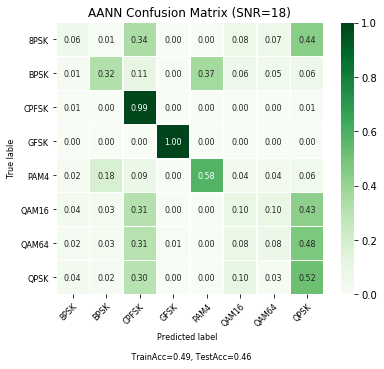

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"AANN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
fig.savefig(dic+f"ANN2-CrossVal-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
print("Plot Saved!")

Plot Saved!
